
## Nonlinear Equalization of a Complex Upsampled Signal


**1. Initialization:**




In [1]:
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split

Load data and plot scatterplot

In [2]:
# Connect notbook with google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Specify data paths where the data for training is stored
x_path='/content/gdrive/MyDrive/Data/x.txt'
y_path='/content/gdrive/MyDrive//Data/y.txt'
a_path='/content/gdrive/MyDrive//Data/a.txt'

In [4]:
#read x data
with open(x_path, "r") as f:
    lines = f.readlines()
x=[]
for line in lines:
    z = complex(line)
    x.append(z)
x=np.array(x)

In [5]:
#read y data
with open(y_path, "r") as f:
  lines = f.readlines()
y = []
for line in lines:
  z = complex(line)
  y.append(z)
y=np.array(y)

In [6]:
#read y data
with open(a_path, "r") as f:
  lines = f.readlines()
a = []
for line in lines:
  z = float(line)
  a.append(z)
a=np.array(a)
a_t = a

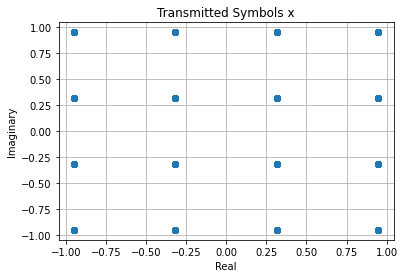

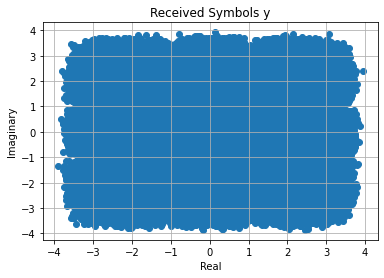

In [7]:
# Divide data sets into real and imaginary parts and plot the scatterplots
x_re = x.real
x_im = x.imag

y_re = y.real
y_im = y.imag

# Create scatterplot for target data x
plt.scatter(x_re, x_im)
plt.title('Transmitted Symbols x')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.grid()
plt.show()

# Create scatterplot for received symbols y
plt.scatter(y_re, y_im)
plt.title('Received Symbols y')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.grid()
plt.show()

In [8]:
# Train sets
x_train, x_test =  train_test_split(x, test_size=0.2, shuffle=False)
y_train, y_test =  train_test_split(y, test_size=0.2, shuffle=False)
a_train, a_test =  train_test_split(a, test_size=0.2, shuffle=False)
# Validation and test sets
x_val, x_test =  train_test_split(x_test, test_size=0.5, shuffle=False)
y_val, y_test =  train_test_split(y_test, test_size=0.5, shuffle=False)
a_val, a_test =  train_test_split(a_test, test_size=0.5, shuffle=False)

print(x_train.size, x_val.size, x_test.size, a_train.size)

1600000 200000 200000 1600000


**2. MSE-Training:**

In [9]:
# Define function to convert data sets to tensors with splited complex numbers
def conv_np_to_complexNumTensor(x, d, col):
  data_re = torch.tensor(np.real(x), dtype=torch.float32).reshape(-1, col)
  data_im = torch.tensor(np.imag(x), dtype=torch.float32).reshape(-1, col)
  return torch.stack([data_re, data_im], dim=d).reshape(-1,(col*2))

In [10]:
# Prepare data to train non-linear equalizer
# Create tensors for training data
x_t_re = torch.tensor(np.real(x_train), dtype=torch.float32).reshape(-1, 1)
x_t_im = torch.tensor(np.imag(x_train), dtype=torch.float32).reshape(-1, 1)
x_t = torch.stack([x_t_re, x_t_im], dim=2).reshape(-1,2)

y_t_re = torch.tensor(np.real(y_train), dtype=torch.float32).reshape(-1, 2)
y_t_im = torch.tensor(np.imag(y_train), dtype=torch.float32).reshape(-1, 2)
#y_t = torch.stack([y_t_re, y_t_im], dim=1).reshape(-1,4)
y_t = torch.stack([y_t_re, y_t_im], dim=2).reshape(-1,4)
#print(y_t_re)
#print(y_t_im)
#print(y_t)
#y_t = torch.stack([y_t_re, y_t_im], dim=2).reshape(-1,4)

# Create tensor of the validation set (y-data)
#y_val_t = conv_np_to_complexNumTensor(y_val,2)
#y_val_t = conv_np_to_complexNumTensor(y_val,1,2)
y_val_t = conv_np_to_complexNumTensor(y_val,2,2)

# Create tensor of the validation set (x-data)
#x_val_t = conv_np_to_complexNumTensor(x_val,1)
x_val_t = conv_np_to_complexNumTensor(x_val,1,1)

# Create tensor of the test set (y-data)
#y_test_t = conv_np_to_complexNumTensor(y_test,2)
#y_test_t = conv_np_to_complexNumTensor(y_test,1,2)
y_test_t = conv_np_to_complexNumTensor(y_test,2,2)

# Create tensor of the test set (x-data)
#x_test_t = conv_np_to_complexNumTensor(x_test,1)
x_test_t = conv_np_to_complexNumTensor(x_test,1,1)

tensor([[-2.0665, -0.2710, -0.9325,  0.2412],
        [-0.0905,  1.9182, -0.2722,  1.3748],
        [-0.6591,  0.4536,  0.4019, -0.4541],
        ...,
        [ 1.8198,  1.6061,  2.7144,  2.1435],
        [ 2.1040,  1.1621, -0.1752,  2.0270],
        [-2.6062,  2.0090, -0.0350,  0.1639]])


In [ ]:
m = nn.AvgPool1d(2, stride=2)
a = m(y_t)
print(a)

<built-in method max of Tensor object at 0x7fdf28ee84f0>


In [20]:
class nonLinEq(nn.Module):
  def __init__(self):
    super().__init__()
    #self.conv= nn.Conv1d(in_channels=6 ,out_channels=20 ,kernel_size= 2, padding='same')
    #self.avgP = nn.AvgPool1d(2, stride=2)
    self.lin1 = nn.Linear(4, 20)
    #self.lin1 = nn.Linear(2, 20)
    self.lin2 = nn.Linear(20,50)
    self.lin3 = nn.Linear(50,30)
    self.lin4 = nn.Linear(30,10)
    self.lin5 = nn.Linear(10,2)
    #self.lin3 = nn.Linear(100,200)
    self.relu1 = nn.ReLU()
    self.relu2 = nn.ReLU()
    self.relu3 = nn.ReLU()
    self.relu4 = nn.ReLU()

  def forward(self, y):
    #y = self.conv(y)
    #y = self.avgP(y)
    y = self.relu1(self.lin1(y))
    y = self.relu2(self.lin2(y))
    y = self.relu3(self.lin3(y))
    y = self.relu4(self.lin4(y))
    return self.lin5(y)

In [21]:
# Define loss function
loss_fn = nn.MSELoss()
lr = 1e-2  # learning rate
batch_size = 100
num_epochs = 30

#Downsample the signal

dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(y_t, x_t),
                                             batch_size=batch_size)
#returns an iteratible dataset -> iterate through it and you get batches
# Initialize NN
torch.manual_seed(5)  # set a seed for reproducible results
nleq = nonLinEq()
optimizer = optim.Adam(nleq.parameters(), lr=lr)

In [16]:
count = 0
for (yi, xi) in (dataloader):
    count=count+1
print(f'For batch size: {batch_size} Number of iterations: {count}')

For batch size: 100 Number of iterations: 16000


In [22]:
# Prellocate space
loss_last_batch = []
loss_val_set = []
# Trainings loop
for j in range(num_epochs):
    for (yi, xi) in (dataloader):
        #y_t = torch.Tensor(yi.reshape(4, 1, -1))
        x_hat = nleq(yi) 
        loss = loss_fn(x_hat, xi)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()              
    # store loss of the last batch 
    loss_last_batch.append(loss.detach().numpy()) #store loss of the last batch 
    # store loss of validation set 
    loss_val = loss_fn(nleq(y_val_t), x_val_t)
    loss_val_set.append(loss_val.detach().numpy())
    
    if j % 2 == 0:
        print(f'epoch {j}: Loss = {loss.detach().numpy() :.4f}')

epoch 0: Loss = 0.0033
epoch 2: Loss = 0.0050
epoch 4: Loss = 0.0026
epoch 6: Loss = 0.0034
epoch 8: Loss = 0.0025
epoch 10: Loss = 0.0021
epoch 12: Loss = 0.0022
epoch 14: Loss = 0.0021
epoch 16: Loss = 0.0026
epoch 18: Loss = 0.0022
epoch 20: Loss = 0.0022
epoch 22: Loss = 0.0028
epoch 24: Loss = 0.0021
epoch 26: Loss = 0.0022
epoch 28: Loss = 0.0022


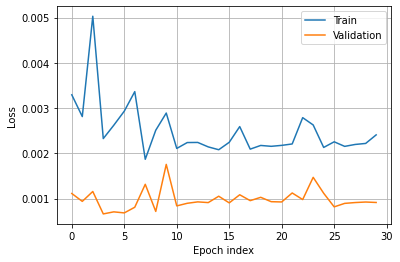

In [23]:
# Plot the loss function of the training and validation set with increasing number of epochs
plt.plot(np.arange(len(loss_last_batch)), loss_last_batch, label="Train")
plt.plot(np.arange(len(loss_val_set)), loss_val_set, label="Validation")
plt.xlabel('Epoch index')
plt.ylabel('Loss')
plt.legend()
plt.grid()

tensor([[-0.9379, -0.3534],
        [-0.2907,  0.9402],
        [-0.3167,  0.3072],
        ...,
        [ 0.9660,  0.9468],
        [ 0.9660,  0.9468],
        [-0.9343,  0.9344]], grad_fn=<AddmmBackward0>)
[[-0.9379234  -0.2907136  -0.3166992  ...  0.9659736   0.96597356
  -0.93426675]]


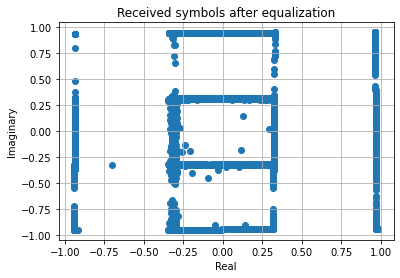

In [24]:
# Feed test data in the trained neuronal network
yeq = nleq(y_test_t)

# Reshape tensors to plot scatterplot
index = torch.tensor([0])
yeq_re = yeq.index_select(1, index).reshape(1,-1).detach().numpy()

index = torch.tensor([1])
yeq_im = yeq.index_select(1, index).reshape(1,-1).detach().numpy()

# Create scatterplot for target data x
plt.scatter(yeq_re[0], yeq_im[0])
plt.title('Received symbols after equalization')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.grid()
plt.show()

**3. Hard-decision mapper:**

In [25]:
def demapper(y_eq,x):
  x_hat=[]
  unique_x_values=np.unique(x)
  for i in y_eq:
    min_arg=np.argmin(abs(unique_x_values-i))
    x_hat.append(unique_x_values[min_arg])
  return x_hat

In [26]:
#Demapping
yeq=yeq.detach().numpy()
yeq_complex=np.vectorize(complex)(yeq[:,0], yeq[:,1])
x_hat=demapper(yeq_complex,x_test)

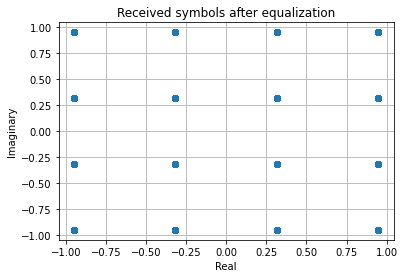

In [27]:
# Create scatterplot for demapped data
plt.scatter(np.real(x_hat), np.imag(x_hat))
plt.title('Received symbols after equalization')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.grid()
plt.show()

Calculate the Symbol Error Rate 

In [28]:
def calculate_SER(x_test,x_hat):
  wrongDetection=0
  for i in np.arange(0,len(x_test)):
    if(x_test[i]!=x_hat[i]):
      wrongDetection+=1
  return (wrongDetection)/len(x_test)

In [29]:
SER=calculate_SER(x_test,x_hat)
print('Symbol error rate:', SER)

Symbol error rate: 0.00405


Calculate the Bit Error Rate

In [30]:
def get_graylabel(m):
    """
    Calculate binary reflected Gray code (BRGC) for m bits.
    """
    if m == 1:
        return np.array([[0], [1]], dtype='uint8')
    else: 
        label = get_graylabel(m -1)
        half_1 = np.hstack((np.zeros((2**(m - 1), 1), dtype='uint8'),
                            label))
        half_2 = np.hstack((np.ones((2**(m - 1), 1), dtype='uint8'), 
                            np.flipud(label)))
        return np.vstack((half_1, half_2))

In [31]:
def MapQAMToGray(x_QAM):
  unique_x_values=np.unique(x_QAM)
  m=int(np.log2(len(unique_x_values)))
  grayLabel=get_graylabel(m)
  #print(f'Gray label for m={m} is:\n {grayLabel}')
  
  unique_x_values[m:2*m]=unique_x_values[m:2*m][::-1]
  unique_x_values[3*m:4*m]=unique_x_values[3*m:4*m][::-1]

  gray_to_QAM={}
  gray_to_QAM = {unique_x_values[i]: grayLabel[i] for i in range(len(grayLabel))}
  x_gray=[]
  for i in x_QAM:
    x_gray.append(gray_to_QAM[i])
  return x_gray

def calculate_BER(x_test,x_hat):
  bitError=0
  for i in np.arange(0,len(x_test)):
    bitError+=sum(x_hat_gray[i]!=x_test_gray[i])
  return bitError/(len(x_test)*4)

In [32]:
x_test_gray=MapQAMToGray(x_test)
x_hat_gray=MapQAMToGray(x_hat)

In [33]:
BER=calculate_BER(x_test_gray,x_hat_gray)
print('Bit error rate:', BER)
print('Symbol error rate:', SER)

Bit error rate: 0.0010125
Symbol error rate: 0.00405


**4.Soft-Decision Demapper**

In [34]:
def softDecisionMapper(input,output):
  unique_x_values=np.unique(input)
  pi=np.zeros([len(output),len(unique_x_values)])
  for i in range(len(output)):
    output_list=np.ones(len(unique_x_values))*output[i]
    sigma=sum(abs(output_list-unique_x_values)**2)/len(unique_x_values)

    denominator=sum(np.exp(-abs(output_list-unique_x_values)**2/(2*sigma)))
    pi[i,:]=np.exp(-abs(output_list-unique_x_values)**2/(2*sigma))
  return pi/denominator

In [ ]:
pi=softDecisionMapper(x_test,yeq_complex)

Equivocation calculation
\\begin{aligned}
\mathbb{H}(X \mid Y) & =\sum_{a \in \mathcal{X}} \sum_{b \in \mathcal{Y}} P_{X Y}(a b)\left[-\log _2 P_{X \mid Y}(a \mid b)\right] \\
& =\mathbb{E}\left[-\log _2 P_{X \mid Y}(X \mid Y)\right] \\
& \approx-\frac{1}{n} \sum_{i=0}^{n-1} \log _2 P_{X \mid Y}\left(x_i \mid y_i\right)
\end{aligned}

In [ ]:
equivocation=sum(-1/len(yeq_complex)*((pi*np.log2(pi)).sum(axis=1)))/len(yeq_complex)
#equivocation = -1/len(yeq_complex)*sum(pi*np.log2(pi))

In [ ]:
equivocation
db = 10*np.log10(equivocation)
print(equivocation)
print(db)

1.9631220876437873e-05
-47.070526905470956


In [ ]:
entropy= -1/16*np.log2(1/16)*16
print(entropy)

4.0


**CE training:**

In [ ]:
# Specify ML model which contains a equalizer and a demapper
class NonLinEqDemapper(nn.Module):
    def __init__(self, n, num_sym): 
        super().__init__()
        self.lin1 = nn.Linear(4,n)
        self.act1 = nn.ReLU()
        self.lin2 = nn.Linear(n,n)
        self.act2 = nn.ReLU()
        self.lin3 = nn.Linear(n,n)
        self.act3 = nn.ReLU()
        self.lin4 = nn.Linear(n,num_sym)
        #self.out = nn.Sigmoid()
        #self.out = nn.Softmax(dim=1)

    def forward(self, y):
        y = self.act1(self.lin1(y))
        y = self.act2(self.lin2(y))
        y = self.act3(self.lin3(y))
        y = self.lin4(y)
        #return self.out(y)
        return y

In [ ]:
batch_size = 1000
num_epochs = 30

#Prepare data
a_t = torch.Tensor(a_train.reshape(-1,))
a_t = a_t.type(torch.LongTensor)

a_v = torch.Tensor(a_val.reshape(-1,))
a_v = a_v.type(torch.LongTensor)

#Downsample the signal
dataloader2 = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(y_t, a_t),
                                             batch_size=batch_size)

# Initialize Network
eq_nl_demap = NonLinEqDemapper(100, 16)
# Define loss function and optimizer
loss_fn_ce = nn.CrossEntropyLoss()
optimizer = optim.Adam(eq_nl_demap.parameters(), lr=1e-2)

In [ ]:
# Prellocate space
loss_ce_last_batch = []
loss_ce_val_set = []
# Trainings loop
for j in range(num_epochs):
    for (yi, ai) in (dataloader2):
        #y_t = torch.Tensor(yi.reshape(4, 1, -1))
        #x_hat = eq_nl_demap(yi)
        logit = eq_nl_demap(yi).reshape(-1, 16)
        loss_ce = loss_fn_ce(logit, ai) #torch.log(x_hat)
        optimizer.zero_grad()
        loss_ce.backward()
        optimizer.step()              
    # store loss of the last batch 
    loss_ce_last_batch.append(loss_ce.detach().numpy()) #store loss of the last batch 
    # store loss of validation set 
    logit_v = eq_nl_demap(y_val_t).reshape(-1, 16)
    loss_val = loss_fn_ce(logit_v, a_v)
    loss_ce_val_set.append(loss_val.detach().numpy())
    
    if j % 2 == 0:
        print(f'epoch {j}: Loss = {loss_ce.detach().numpy() :.4f}')

epoch 0: Loss = 0.0119
epoch 2: Loss = 0.0083
epoch 4: Loss = 0.0209
epoch 6: Loss = 0.0078
epoch 8: Loss = 0.0073
epoch 10: Loss = 0.0064
epoch 12: Loss = 0.0227
epoch 14: Loss = 0.0064
epoch 16: Loss = 0.0063
epoch 18: Loss = 0.0050
epoch 20: Loss = 0.0057
epoch 22: Loss = 0.0062
epoch 24: Loss = 0.0127
epoch 26: Loss = 0.0192
epoch 28: Loss = 0.0152


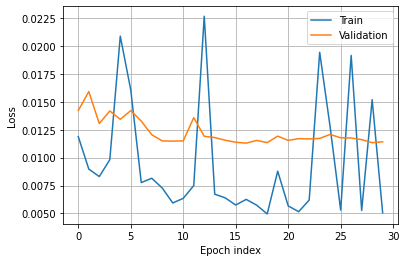

In [ ]:
# Plot the loss function of the training and validation set with increasing number of epochs
plt.plot(np.arange(len(loss_ce_last_batch)), loss_ce_last_batch, label="Train")
plt.plot(np.arange(len(loss_ce_val_set)), loss_ce_val_set, label="Validation")
plt.xlabel('Epoch index')
plt.ylabel('Loss')
plt.legend()
plt.grid()

In [ ]:
def calculate_SoftDemap_SER(prob_eq, a_t):
  p = prob_eq.detach().numpy()
  symError=0

  for i in np.arange(0,len(a_t)):
    if (p[i,:].max() < 0.5):
      symError = symError + 1
    else:
      if (p[i,:].argmax() != int(a_t[i])):
        symError = symError + 1

  return symError/(len(a_t))

In [ ]:
def calculate_SoftDemap_SER2(prob_eq, a_t):
  p = prob_eq.detach().numpy()
  symError=0

  for i in np.arange(0,len(a_t)):
    if (p[i,:].argmax() != int(a_t[i])):
      symError = symError + 1

  return symError/(len(a_t))

In [ ]:
# Calculate symbol probabilities for the test set
l = eq_nl_demap(y_test_t).reshape(-1, 16)
out = nn.Softmax(dim=1)
prob_sym = out(l)
ser = calculate_SoftDemap_SER2(prob_sym, a_test)
print('Symbol error rate:', ser)

Symbol error rate: 0.003655


In [ ]:
def calc_equivo(prob_eq):
  p = prob_eq.detach().numpy()
  equi=sum(-1/len(p)*((p*np.log2(p)).sum(axis=1)))/len(p)
  return equi

In [ ]:
p = prob_sym.detach().numpy()